In [1]:
%matplotlib inline
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'

In [2]:
from matplotlib import rc
rc('font', **{'size':20})
rc('text', usetex=False)
rc('xtick', labelsize=20) #20 
rc('ytick', labelsize=20) #20
rc('axes', titlesize=20)    # fontsize of the axes title
rc('axes', labelsize=20) 

In [3]:
expt = '01deg_jra55v140_iaf_cycle3'
session = cc.database.create_session()

In [59]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43865/status,
Dashboard: /proxy/43865/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44667,Workers: 7
Dashboard: /proxy/43865/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:41963,Total threads: 4
Dashboard: /proxy/33619/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:37979,


In [6]:
import gc
client.run(gc.collect)

{'tcp://127.0.0.1:32843': 56,
 'tcp://127.0.0.1:36171': 56,
 'tcp://127.0.0.1:36429': 56,
 'tcp://127.0.0.1:40255': 56,
 'tcp://127.0.0.1:43399': 56,
 'tcp://127.0.0.1:46557': 56,
 'tcp://127.0.0.1:46587': 56}

In [7]:
chunk = {'yu_ocean':52, 'xu_ocean':1200}
# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Binned_ASC_speed/OM2_IAF/Binned_Antarctic_slope_contour_1km_velocities*')
# Load CSHT field
CSHT_along = xr.open_mfdataset(\
    '/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')

In [8]:
# Average U_along into mean, seasonal, monthly and annual fields

u_along_da_mean = u_along.mean('time').u_along_contour_binned
u_along_da_seasonal = u_along.groupby('time.month').mean('time').u_along_contour_binned
u_along_da_annual = u_along.groupby('time.year').mean('time').u_along_contour_binned
## CHECK: Is this the right way? 
u_along_da_monthly = u_along.resample(time='1M').mean().u_along_contour_binned

#u_along_da_mean.load()
#u_along_da_seasonal.load()
#u_along_da_annual.load()
u_along_da_monthly.load()

<xarray.DataArray 'u_along_contour_binned' (time: 732, st_ocean: 75,
                                            lon_bin_midpoints: 1428)> Size: 627MB
array([[[-0.02359511, -0.02475564, -0.02657239, ..., -0.0204653 ,
         -0.02053152, -0.02350026],
        [-0.01865366, -0.01979311, -0.02162974, ..., -0.01303114,
         -0.01375674, -0.01694079],
        [-0.01603528, -0.01716227, -0.01901062, ..., -0.00900011,
         -0.0100713 , -0.01337444],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.06889385, -0.06873107, -0.06851074, ..., -0.02077237,
         -0.02169113, -0.02693162],
        [-0.06278588, -0.06240495, -0.06204439, ..., -0.01473967,
         -0.01655271, -0.02205193],
        [-0.05906674, -0.05856833, -0.05814252, ..., -0.01109173,
         -0.01338399, -0.0190114 ],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.0376156 , -0.03683981, -0.03611625, ..., -0.03758969,
         -0.03398371, -0.03630787],
        [-0.03121829, -0.0303874 , -0.02965705, ..., -0.0294911 ,
         -0.02702347, -0.02966545],
        [-0.02686711, -0.02600385, -0.02527127, ..., -0.02429345,
         -0.0225731 , -0.02540491],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * st_ocean           (st_ocean) float64 600B 0.5413 1.681 ... 5.709e+03
  * lon_bin_midpoints  (lon_bin_midpoints) float64 11kB -278.5 -278.2 ... 78.25
  * time               (time) datetime64[ns] 6kB 1958-01-31 ... 2018-12-31

## Assess u_along and CSHT in regimes

In [9]:
clustering_mask = xr.open_mfdataset('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc')
regime_mask = clustering_mask.regimes_mask.load()

In [10]:
masked_u_along = u_along_da_monthly.rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})*clustering_mask
masked_u_along.load()

<xarray.Dataset> Size: 2GB
Dimensions:       (regime: 3, lon: 1428, depth: 75, time: 732)
Coordinates:
  * regime        (regime) <U7 84B 'Surface' 'Reverse' 'Deep'
  * lon           (lon) float64 11kB -278.5 -278.2 -278.0 ... 77.75 78.0 78.25
  * depth         (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time          (time) datetime64[ns] 6kB 1958-01-31 1958-02-28 ... 2018-12-31
Data variables:
    regimes_mask  (time, depth, lon, regime) float64 2GB -0.0236 nan ... nan nan

In [11]:
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()
CSHT_months = ((CSHT_along_monthly.binned_cross_slope_heat_trans+CSHT_along_monthly.zonal_convergence)*0.08).rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})

In [12]:
masked_CSHT = CSHT_months*clustering_mask
masked_CSHT.load()

<xarray.Dataset> Size: 2GB
Dimensions:       (regime: 3, lon: 1428, depth: 75, time: 732)
Coordinates:
  * regime        (regime) <U7 84B 'Surface' 'Reverse' 'Deep'
  * lon           (lon) float64 11kB -278.5 -278.2 -278.0 ... 77.75 78.0 78.25
  * depth         (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time          (time) datetime64[ns] 6kB 1958-01-31 1958-02-28 ... 2018-12-31
Data variables:
    regimes_mask  (time, depth, lon, regime) float64 2GB -5.01e+09 nan ... nan

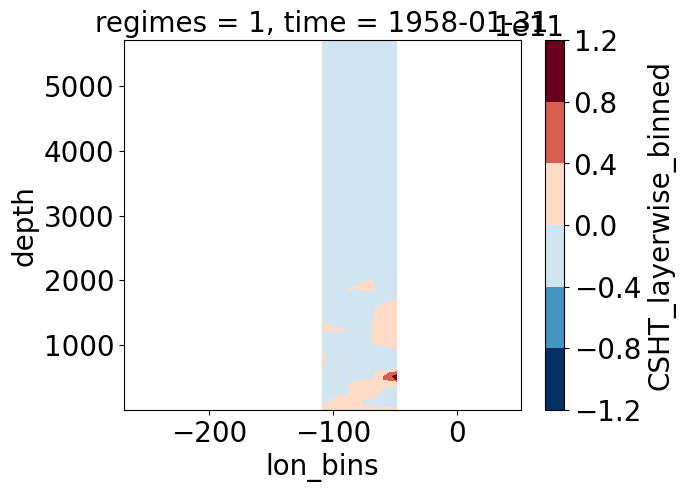

In [13]:
CSHT_layerwise_binned = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/CSHT_layerwise_20degBins.nc').CSHT_layerwise_binned.load()
(CSHT_layerwise_binned[1,0,:,:]).plot.contourf()

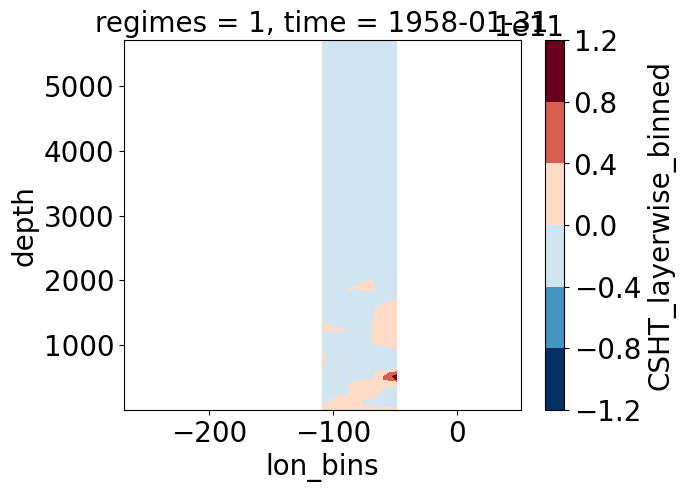

In [71]:
CSHT_layerwise_binned[1,0,:,:].where(~np.isnan(CSHT_layerwise_binned[1,0,:,:]), CSHT_layerwise_binned[1,0,:,:]).plot.contourf()

## add the weighting of lon bins here

In [14]:
## getting p-values from binned data
CSHT_layerwise_binned = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/CSHT_layerwise_20degBins.nc').CSHT_layerwise_binned.load()
u_along_layerwise_binned = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/u_along_da_months_20degBins.nc').u_along_da_months_binned.load()
#u_along_da_mean = u_along_layerwise_binned.mean('time').u_along_contour_binned


In [15]:
# 20deg
files_path = '/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/'
ds = xr.open_dataset(files_path + 'slope_annual_20degBins.nc')
slope_annual_20deg = ds.slope_annual
depth_20deg = ds.depth
ds.close()
ds = xr.open_dataset(files_path + 'slope_all_20degBins.nc')
slope_all_20deg = ds.slope_all
ds.close()
ds = xr.open_dataset(files_path + 'slope_clima_20degBins.nc')
slope_clima_20deg = ds.slope_clima
ds.close()
ds = xr.open_dataset(files_path + 'stderr_annual_20degBins.nc')
stderr_annual_20deg = ds.stderr_annual
ds.close()
ds = xr.open_dataset(files_path + 'stderr_all_20degBins.nc')
stderr_all_20deg = ds.stderr_all
ds.close()
ds = xr.open_dataset(files_path + 'stderr_clima_20degBins.nc')
stderr_clima_20deg = ds.stderr_clima
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_annual_20degBins.nc')
r_sq_annual_20deg = ds.r_sq_annual
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_all_20degBins.nc')
r_sq_all_20deg = ds.r_sq_all
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_clima_20degBins.nc')
r_sq_clima_20deg = ds.r_sq_clim
ds.close()

In [16]:
u_along_layerwise_binned

<xarray.DataArray 'u_along_da_months_binned' (regimes: 3, time: 732, depth: 50,
                                              lon_bins: 17)> Size: 15MB
array([[[[-8.42439430e-02, -8.35986318e-02, -6.10087633e-02, ...,
          -1.41636231e-01, -1.17325292e-01, -1.39485898e-01],
         [-7.86500966e-02, -7.40881376e-02, -5.30371871e-02, ...,
          -1.28359695e-01, -1.07058661e-01, -1.19604188e-01],
         [-7.39350297e-02, -6.63369631e-02, -4.60810797e-02, ...,
          -1.16966021e-01, -9.81009068e-02, -1.05039335e-01],
         ...,
         [-1.53504972e-02, -8.27344022e-03, -5.83919072e-03, ...,
           6.06328255e-03,  5.38187887e-04, -8.33520099e-03],
         [-1.21928781e-02, -8.26077046e-03, -6.05036807e-03, ...,
           5.43987657e-03,  6.25815439e-04, -6.02743505e-03],
         [-1.03715809e-02, -7.41109943e-03, -7.50637484e-03, ...,
           3.41905951e-03, -2.53595747e-04, -4.64313286e-03]],

        [[-1.27622535e-01, -1.02952219e-01, -8.04385187e-02, ...,
          -2.86924715e-01, -1.99183812e-01, -1.69755534e-01],
         [-1.19559149e-01, -9.49551979e-02, -7.25855662e-02, ...,
          -2.68612688e-01, -1.88256474e-01, -1.54964159e-01],
         [-1.13291967e-01, -8.87519406e-02, -6.63274760e-02, ...,
          -2.53470852e-01, -1.79138888e-01, -1.44304473e-01],
...
         [            nan,             nan, -3.35688967e-02, ...,
                      nan,             nan, -4.85530636e-03],
         [            nan,             nan, -2.74471171e-02, ...,
                      nan,             nan, -6.08498645e-03],
         [            nan,             nan, -1.75173161e-02, ...,
                      nan,             nan, -2.15065817e-03]],

        [[            nan,             nan, -5.31051211e-02, ...,
                      nan,             nan, -5.26756178e-02],
         [            nan,             nan, -4.56039751e-02, ...,
                      nan,             nan, -3.82201852e-02],
         [            nan,             nan, -3.98390009e-02, ...,
                      nan,             nan, -2.66291044e-02],
         ...,
         [            nan,             nan, -4.29286464e-02, ...,
                      nan,             nan, -1.36636755e-02],
         [            nan,             nan, -3.52354441e-02, ...,
                      nan,             nan, -1.54788786e-02],
         [            nan,             nan, -2.17792934e-02, ...,
                      nan,             nan, -1.30310296e-02]]]])
Coordinates:
  * regimes   (regimes) int64 24B 0 1 2
  * time      (time) datetime64[ns] 6kB 1958-01-31 1958-02-28 ... 2018-12-31
  * depth     (depth) float64 400B 0.000406 0.001261 0.002205 ... 0.9154 1.0
  * lon_bins  (lon_bins) float64 136B -268.5 -248.5 -228.5 ... 11.5 31.5 51.5

In [17]:
# annual avg whole IAF
u_along_da_mean_masked = u_along_da_mean.expand_dims(dim={"regime": 3})
u_along_da_mean_masked = u_along_da_mean_masked*regime_mask
u_along_da_mean_masked

<xarray.DataArray (regime: 3, st_ocean: 75, lon_bin_midpoints: 1428, lon: 1428)> Size: 4GB
dask.array<mul, shape=(3, 75, 1428, 1428), dtype=float64, chunksize=(3, 75, 1428, 1428), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean           (st_ocean) float64 600B 0.5413 1.681 ... 5.709e+03
  * lon_bin_midpoints  (lon_bin_midpoints) float64 11kB -278.5 -278.2 ... 78.25
  * regime             (regime) <U7 84B 'Surface' 'Reverse' 'Deep'
  * lon                (lon) float64 11kB -278.5 -278.2 -278.0 ... 78.0 78.25

In [18]:
lon_bin=20
bin_edges = np.arange(u_along_da_mean_masked.lon[0], u_along_da_mean_masked.lon[-1:], lon_bin)
# print(bin_edges.shape)
weight_20deg = np.empty((17,3))

for rr in range(0,3):
    for aa in range(0,17):
        lower_lon = bin_edges[aa]
        upper_lon = bin_edges[aa+1]
        '''
        pts_w_range = u_along_da_seasons_masked.lon[(u_along_da_seasons_masked.isel(regime=rr).lon*regime_mask.isel(regime=rr) >= lower_lon) 
                                                    & (u_along_da_seasons_masked.isel(regime=rr).lon*regime_mask.isel(regime=rr) < upper_lon)]
        '''
        pts_w_range = u_along_da_mean_masked.lon[(u_along_da_mean_masked.isel(regime=rr).lon*regime_mask.isel(regime=rr) >= lower_lon) 
                                            & (u_along_da_mean_masked.isel(regime=rr).lon*regime_mask.isel(regime=rr) < upper_lon)]
        # print(len(pts_w_range))
        npts = len(pts_w_range)
        # print('lon interv.: ', lower_lon, upper_lon) 
        # print(npts)
        weight_20deg[aa,rr] = npts
        del pts_w_range, npts
    

In [19]:
weight_20deg_pct = np.divide(weight_20deg,80)
weight_20deg_sum = np.nansum(weight_20deg_pct,0)


In [20]:
# depth4plot = depth_20deg

slope_annual_wavg_20deg = np.divide(np.nansum(slope_annual_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)
slope_all_wavg_20deg = np.divide(np.nansum(slope_all_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)
slope_clima_wavg_20deg = np.divide(np.nansum(slope_clima_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)

stderr_annual_wavg_20deg = np.divide(np.nansum(stderr_annual_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)
stderr_all_wavg_20deg = np.divide(np.nansum(stderr_all_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)
stderr_clima_wavg_20deg = np.divide(np.nansum(stderr_clima_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)

r_sq_annual_wavg_20deg = np.divide(np.nansum(r_sq_annual_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)
r_sq_all_wavg_20deg = np.divide(np.nansum(r_sq_all_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)
r_sq_clima_wavg_20deg = np.divide(np.nansum(r_sq_clima_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)

# average r^2 800 and bottom;

r_sq_annual_plot_20deg = np.divide(np.nansum(r_sq_annual_20deg[-7:,:,:]*weight_20deg_pct, axis=0),weight_20deg_sum)
r_sq_all_plot_20deg = np.divide(np.nansum(r_sq_all_20deg[-7:,:,:]*weight_20deg_pct, axis=0),weight_20deg_sum)
r_sq_clima_plot_20deg = np.divide(np.nansum(r_sq_clima_20deg[-7:,:,:]*weight_20deg_pct, axis=0),weight_20deg_sum)

In [21]:
r_sq_annual_plot_20deg.shape

(17, 3)

In [22]:
r_sq_annual_20deg.depth[-7:]

<xarray.DataArray 'depth' (depth: 7)> Size: 56B
array([ 766.066772,  843.025513,  926.648193, 1017.243713, 1115.067993,
       1220.309448, 1333.07605 ])
Coordinates:
  * depth    (depth) float64 56B 766.1 843.0 926.6 ... 1.22e+03 1.333e+03

## plotting here

In [23]:
classes = ['Surface', 'Reverse', 'Deep']

In [24]:
u_along_layerwise_binned.depth

<xarray.DataArray 'depth' (depth: 50)> Size: 400B
array([4.060389e-04, 1.260794e-03, 2.205390e-03, 3.249268e-03, 4.402862e-03,
       5.677703e-03, 7.086531e-03, 8.643426e-03, 1.036395e-02, 1.226528e-02,
       1.436643e-02, 1.668837e-02, 1.925431e-02, 2.208985e-02, 2.522332e-02,
       2.868596e-02, 3.251233e-02, 3.674056e-02, 4.141279e-02, 4.657554e-02,
       5.228015e-02, 5.858331e-02, 6.554756e-02, 7.324188e-02, 8.174233e-02,
       9.113273e-02, 1.015054e-01, 1.129619e-01, 1.256140e-01, 1.395843e-01,
       1.550073e-01, 1.720304e-01, 1.908144e-01, 2.115348e-01, 2.343821e-01,
       2.595626e-01, 2.872984e-01, 3.178276e-01, 3.514034e-01, 3.882930e-01,
       4.287752e-01, 4.731370e-01, 5.216693e-01, 5.746610e-01, 6.323912e-01,
       6.951203e-01, 7.630800e-01, 8.364624e-01, 9.154087e-01, 1.000000e+00])
Coordinates:
  * depth    (depth) float64 400B 0.000406 0.001261 0.002205 ... 0.9154 1.0

In [25]:
## Average over different time scales to get depth-based correlations
'''
CSHT_annual = masked_CSHT.mean('lon').groupby('time.year').mean('time')
U_along_annual = masked_u_along.mean('lon').groupby('time.year').mean('time')

CSHT_clima = masked_CSHT.groupby('time.month').mean('time').mean('lon')
U_along_clima = masked_u_along.groupby('time.month').mean('time').mean('lon')
'''
CSHT_layerwise = CSHT_layerwise_binned#.mean('lon_bins')#.regimes_mask
U_along_layerwise = u_along_layerwise_binned#.mean('lon_bins')#.regimes_mask

#CSHT_depthav = masked_CSHT.mean('lon').mean('depth').regimes_mask
U_along_depthav = u_along_layerwise_binned.weighted(u_along_layerwise_binned.depth).mean('depth')#.mean('lon_bins').regimes_mask
U_along_depthav

<xarray.DataArray 'u_along_da_months_binned' (regimes: 3, time: 732,
                                              lon_bins: 17)> Size: 299kB
array([[[-0.03134011, -0.01897148, -0.01689747, ...,  0.0009396 ,
         -0.01280126, -0.02166807],
        [-0.03749069, -0.02998104, -0.02607468, ..., -0.01492941,
         -0.02756126, -0.03298799],
        [-0.06643805, -0.05732638, -0.03719108, ..., -0.03068814,
         -0.05794769, -0.0542625 ],
        ...,
        [-0.05654346, -0.03536565, -0.02423612, ..., -0.00872146,
         -0.01429333, -0.02252086],
        [-0.04051225, -0.03110751, -0.02102681, ..., -0.01365912,
         -0.02435198, -0.01999077],
        [-0.03299431, -0.01404763, -0.01429497, ..., -0.00799873,
         -0.0113164 , -0.01017255]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan, -0.02724632, ...,         nan,
                 nan, -0.02963616],
        [        nan,         nan, -0.03487889, ...,         nan,
                 nan, -0.03164014],
        [        nan,         nan, -0.02857494, ...,         nan,
                 nan, -0.05227284],
        ...,
        [        nan,         nan, -0.03044485, ...,         nan,
                 nan, -0.02158307],
        [        nan,         nan, -0.02669967, ...,         nan,
                 nan, -0.00569151],
        [        nan,         nan, -0.03420065, ...,         nan,
                 nan, -0.00899949]]])
Coordinates:
  * regimes   (regimes) int64 24B 0 1 2
  * time      (time) datetime64[ns] 6kB 1958-01-31 1958-02-28 ... 2018-12-31
  * lon_bins  (lon_bins) float64 136B -268.5 -248.5 -228.5 ... 11.5 31.5 51.5

In [26]:
#slope_all = np.zeros((masked_u_along.depth.size, 3, len(u_along_layerwise_binned.lon_bins)))
#stderr_all = np.zeros((masked_u_along.depth.size, 3, len(u_along_layerwise_binned.lon_bins)))
#r_sq_all = np.zeros((masked_u_along.depth.size, 3, len(u_along_layerwise_binned.lon_bins)))
slope_depthav = np.zeros((u_along_layerwise_binned.depth.size, 3, len(u_along_layerwise_binned.lon_bins)))
stderr_depthav = np.zeros((u_along_layerwise_binned.depth.size, 3, len(u_along_layerwise_binned.lon_bins)))
r_sq_depthav = np.zeros((u_along_layerwise_binned.depth.size, 3, len(u_along_layerwise_binned.lon_bins)))
pval_depthav = np.zeros((u_along_layerwise_binned.depth.size, 3, len(u_along_layerwise_binned.lon_bins)))
pval_all = np.zeros((u_along_layerwise_binned.depth.size, 3, len(u_along_layerwise_binned.lon_bins)))

'''
slope_deseasoned = np.zeros((masked_u_along.depth.size, 3))
stderr_deseasoned = np.zeros((masked_u_along.depth.size, 3))
r_sq_deseasoned = np.zeros((masked_u_along.depth.size, 3))
slope_clima = np.zeros((masked_u_along.depth.size, 3))
stderr_clima = np.zeros((masked_u_along.depth.size, 3))
r_sq_clima = np.zeros((masked_u_along.depth.size, 3))
'''
for i in range(3):
    for j in range(u_along_layerwise_binned.depth.size):
        for l in range(u_along_layerwise_binned.lon_bins.size):
        
        #        slope_all[j,i] = stats.linregress(U_along_layerwise[:,:,j,i][~np.isnan(CSHT_layerwise[:,:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,:,j,i])]/1e12).slope
        #        stderr_all[j,i] = stats.linregress(U_along_layerwise[:,:,j,i][~np.isnan(CSHT_layerwise[:,:,j,i])], CSHT_layerwise[:,:,j,i][~np.isnan(CSHT_layerwise[:,:,j,i])]/1e12).stderr
        #        r_sq_all[j,i] = stats.linregress(U_along_layerwise[:,:,j,i][~np.isnan(CSHT_layerwise[:,:,j,i])], CSHT_layerwise[:,:,j,i][~np.isnan(CSHT_layerwise[:,:,j,i])]/1e12).rvalue**2
            slope_depthav[j,i,l] =stats.linregress(U_along_depthav[i,:,l].where(~np.isnan(CSHT_layerwise_binned[i,:,j,l]), U_along_depthav[i,:,l]) , CSHT_layerwise_binned[i,:,j,l].where(~np.isnan(CSHT_layerwise_binned[i,:,j,l]), CSHT_layerwise_binned[i,:,j,l]) /1e12).slope
            stderr_depthav[j,i,l] = stats.linregress(U_along_depthav[i,:,l].where(~np.isnan(CSHT_layerwise_binned[i,:,j,l]), U_along_depthav[i,:,l]) , CSHT_layerwise_binned[i,:,j,l].where(~np.isnan(CSHT_layerwise_binned[i,:,j,l]), CSHT_layerwise_binned[i,:,j,l]) /1e12).stderr
            r_sq_depthav[j,i,l] =stats.linregress(U_along_depthav[i,:,l].where(~np.isnan(CSHT_layerwise_binned[i,:,j,l]), U_along_depthav[i,:,l]) , CSHT_layerwise_binned[i,:,j,l].where(~np.isnan(CSHT_layerwise_binned[i,:,j,l]), CSHT_layerwise_binned[i,:,j,l]) /1e12).rvalue**2
            
            pval_all[j,i,l] = 1-stats.linregress(U_along_layerwise[i,:,j,l].where(~np.isnan(CSHT_layerwise_binned[i,:,j,l]), U_along_layerwise[i,:,j,l]) , CSHT_layerwise_binned[i,:,j,l].where(~np.isnan(CSHT_layerwise_binned[i,:,j,l]), CSHT_layerwise_binned[i,:,j,l]) /1e12).pvalue
            pval_depthav[j,i,l] = 1-stats.linregress(U_along_depthav[i,:,l].where(~np.isnan(CSHT_layerwise_binned[i,:,j,l]), U_along_depthav[i,:,l]) , CSHT_layerwise_binned[i,:,j,l].where(~np.isnan(CSHT_layerwise_binned[i,:,j,l]), CSHT_layerwise_binned[i,:,j,l]) /1e12).pvalue

(50, 3, 17)

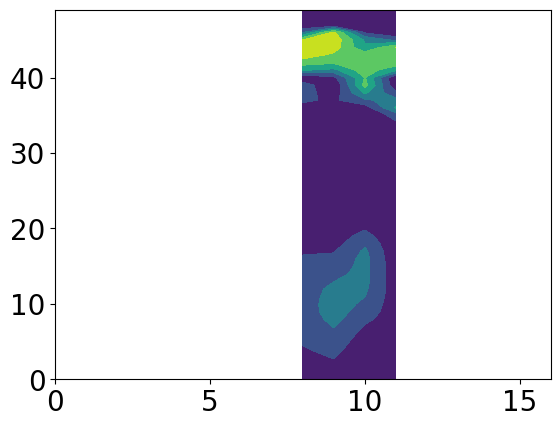

In [27]:
plt.contourf(r_sq_depthav[:,1,:])
r_sq_depthav.shape

In [28]:
np.nanmean(r_sq_depthav[:,1,:], axis = 1)

array([0.02526108, 0.04399552, 0.05923993, 0.07422504, 0.0902591 ,
       0.10814397, 0.12818471, 0.14852286, 0.16665819, 0.18161713,
       0.18917258, 0.19277542, 0.19405991, 0.1886646 , 0.17995585,
       0.16841883, 0.15127176, 0.12334157, 0.08932885, 0.05914051,
       0.03631556, 0.02110236, 0.01278236, 0.01100062, 0.01307962,
       0.01646568, 0.01907835, 0.01896534, 0.01784758, 0.01616362,
       0.01545958, 0.02013689, 0.0281534 , 0.03241256, 0.05351568,
       0.06497098, 0.14410349, 0.18648796, 0.18758109, 0.18376021,
       0.15216111, 0.41276844, 0.54499475, 0.63131967, 0.6433337 ,
       0.5506939 , 0.31080671, 0.01064187, 0.01767426, 0.01479175])

In [29]:
r_sq_depthav_binned_av = np.nanmean(r_sq_depthav,axis = 2)
r_sq_depthav_binned_av[:,1] = np.nanmean(r_sq_depthav[:,1,:], axis = 1)
pval_depthav_binned_av = np.nanmean(pval_depthav,axis = 2)
pval_binned_av = np.nanmean(pval_all,axis = 2)
r_sq_depthav_binned_av.shape

(50, 3)

In [32]:
 np.nanmean(r_sq_depthav[:,2,:], axis = 1) ==r_sq_depthav_binned_av[:,2]  # checking that warm regime not working is a one off nan issue

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [30]:
weight_20deg_sum

array([11.025 ,  2.7625,  3.2125])

In [31]:
# average r^2 800 and bottom, ONLY AVERAGING OVER SIGNIFICANT VALUES IN LOWER 766-1333m 
r_sq_annual_plot_20deg_sig = np.asarray([np.divide(np.nansum(r_sq_annual_20deg[-7:,:,rr]*weight_20deg_pct[:,rr]*pval_all[-7:,rr,:], axis=0),weight_20deg_sum[rr]) for rr in range(3)])
r_sq_all_plot_20deg_sig = [np.divide(np.nansum(r_sq_all_20deg[-7:,:,rr]*weight_20deg_pct[:,rr]*pval_all[-7:,rr,:], axis=0),weight_20deg_sum[rr])for rr in range(3)]
r_sq_clima_plot_20deg_sig = [np.divide(np.nansum(r_sq_clima_20deg[-7:,:,rr]*weight_20deg_pct[:,rr]*pval_all[-7:,rr,:], axis=0),weight_20deg_sum[rr]) for rr in range(3)]

In [32]:
r_sq_annual_plot_20deg_sig.shape

(3, 17)

## Bathymetry for plotting

In [33]:
# Import bathymetry
lat_slice = slice(-80, -59)
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()

In [34]:
# For polar projection
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.45
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Data required for lat/lon mapping
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# Make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

# Fontsize
ft_size = 16

In [35]:
lon_along_contour = CSHT_along.lon_along_contour
lat_along_contour = CSHT_along.lat_along_contour

Text(0.5, 0, 'Latitude')

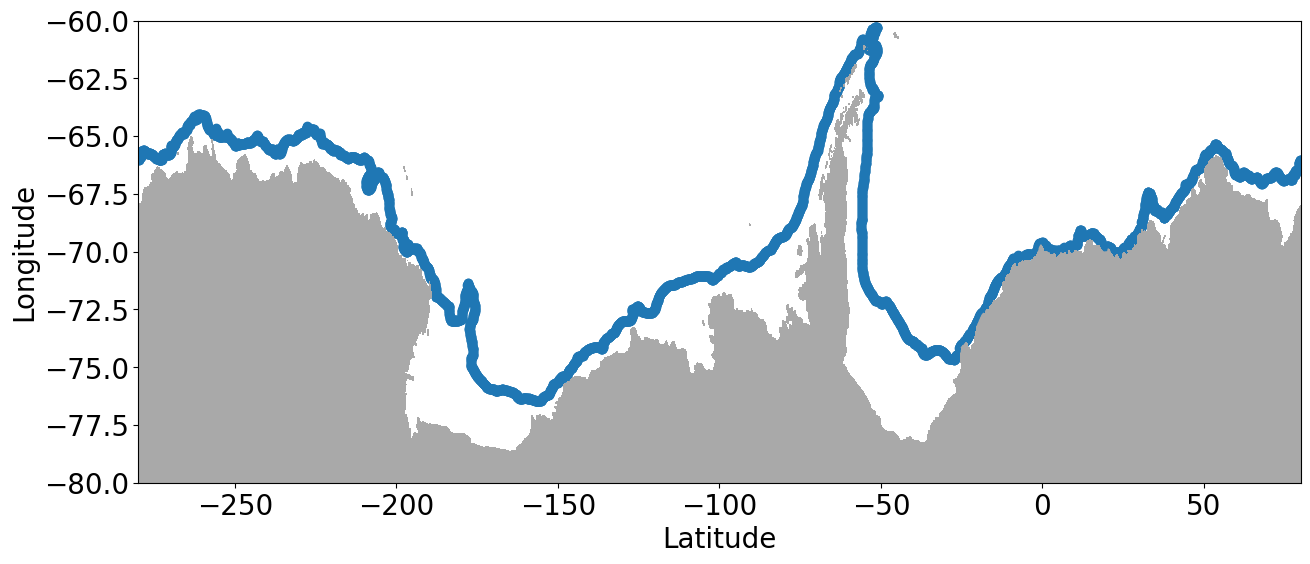

In [36]:
## Plot regions on antarctica ## USING 6002 CONTOUR INDEX
plt.figure(figsize = (15,6))
sc = plt.scatter(CSHT_along.lon_along_contour.isel(time = 0, st_ocean = 0), CSHT_along.lat_along_contour.isel(time = 0, st_ocean = 0))
plt.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
plt.plot(CSHT_along.lon_along_contour.isel(time = 0, st_ocean = 0), CSHT_along.lat_along_contour.isel(time = 0, st_ocean = -1))
plt.ylim([-80,-60])
plt.ylabel('Longitude')
plt.xlabel('Latitude')

In [37]:
# assigining numbers by regime clustering mask
import matplotlib
colorsList_no3 = [('mediumseagreen'),('tomato'),('blueviolet')]
CustomCmap_no3 = matplotlib.colors.ListedColormap(colorsList_no3)

clustering_mask_sum = xr.concat([clustering_mask.regimes_mask.isel(regime = reg_no) * (reg_no+1) for reg_no in range(3)], dim = 'regime').sum(dim = 'regime')
clustering_mask_sum

<xarray.DataArray 'regimes_mask' (lon: 1428)> Size: 11kB
array([1., 1., 1., ..., 1., 1., 1.])
Coordinates:
  * lon      (lon) float64 11kB -278.5 -278.2 -278.0 -277.8 ... 77.75 78.0 78.25

In [41]:
r_sq_annual_plot_20deg.shape

(17, 3)

In [42]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## extending binned data for plotting
Currently directly plotting the scatter for the binned data results in lots of gaps. 
This extrapolates the binned areas to a larger region

In [38]:
## importing 5 deg binned circumpolar correlations
binned_corr = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/r_sq_all_20degBins.nc')
da_binned_corr_av = xr.DataArray(data = r_sq_annual_plot_20deg_sig.T, dims = ['lon_bin_mid', 'regimes'], coords = {'lon_bin_mid': binned_corr.lon_bin_mid, 'regimes': range(3)})
binned_corr_av = da_binned_corr_av #binned_corr.sel(depth = slice(600,1000)).mean(dim = 'depth')

In [39]:
CSHT_lon_along_contour = CSHT_along.lon_along_contour.isel(time = 0, st_ocean = 0).values
CSHT_lat_along_contour = CSHT_along.lat_along_contour.isel(time = 0, st_ocean = 0).values

In [40]:
binned_corr_lon_bins = binned_corr.lon_bins.values

In [41]:
## Takes a while! 
## improving the plotting by extrapolating 5 deg bins into original contour CSHT_lon_along_contour so plot is nicer
binned_corr_av_ext = np.zeros((len(CSHT_lon_along_contour),3))

n = 20 # no of degrees binning

XX = 0
for check_ll in range(len(CSHT_lon_along_contour)): # new longer lon
    print('ll = ', check_ll)
    for xx in range(XX, len(binned_corr_lon_bins)): # binned lon
        if (CSHT_lon_along_contour[check_ll] > binned_corr_lon_bins[xx] -n/2) & (CSHT_lon_along_contour[check_ll] < binned_corr_lon_bins[xx]+n/2 ):
            print('selecting', CSHT_lon_along_contour[check_ll] , binned_corr_lon_bins[xx])
            binned_corr_av_ext[check_ll,:] = binned_corr_av.isel(lon_bin_mid = xx).values

ll =  0
ll =  1
ll =  2
ll =  3
ll =  4
ll =  5
ll =  6
ll =  7
ll =  8
ll =  9
ll =  10
ll =  11
ll =  12
ll =  13
ll =  14
ll =  15
ll =  16
ll =  17
ll =  18
ll =  19
ll =  20
ll =  21
ll =  22
ll =  23
ll =  24
ll =  25
selecting -278.49999999999966 -268.5
ll =  26
selecting -278.39999999999964 -268.5
ll =  27
selecting -278.39999999999964 -268.5
ll =  28
selecting -278.2999999999996 -268.5
ll =  29
selecting -278.1999999999996 -268.5
ll =  30
selecting -278.09999999999957 -268.5
ll =  31
selecting -277.99999999999955 -268.5
ll =  32
selecting -278.09999999999957 -268.5
ll =  33
selecting -277.8999999999995 -268.5
ll =  34
selecting -277.7999999999995 -268.5
ll =  35
selecting -277.6999999999995 -268.5
ll =  36
selecting -277.59999999999945 -268.5
ll =  37
selecting -277.6999999999995 -268.5
ll =  38
selecting -277.49999999999943 -268.5
ll =  39
selecting -277.3999999999994 -268.5
ll =  40
selecting -277.2999999999994 -268.5
ll =  41
selecting -277.19999999999936 -268.5
ll =  42
se

In [42]:
da_binned_corr_av_ext = xr.DataArray(data = binned_corr_av_ext, dims = ['lon_along_contour', 'regimes'], coords = {'lon_along_contour': CSHT_lon_along_contour, 'regimes': range(3)})

In [43]:
da_binned_corr_av_ext

<xarray.DataArray (lon_along_contour: 6002, regimes: 3)> Size: 144kB
array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])
Coordinates:
  * lon_along_contour  (lon_along_contour) float64 48kB -279.9 -279.8 ... 80.0
  * regimes            (regimes) int64 24B 0 1 2

In [44]:
da_binned_corr_max = da_binned_corr_av_ext.max( dim = 'regimes')

In [45]:
## PDF for plotting
from sklearn.neighbors import KernelDensity
from matplotlib.colors import LinearSegmentedColormap, to_rgb

In [46]:
CSHT_layerwise_binned.depth.isel(depth=slice(37,50))

<xarray.DataArray 'depth' (depth: 13)> Size: 104B
array([ 423.688324,  468.44751 ,  517.624146,  571.589905,  630.727539,
        695.424805,  766.066772,  843.025513,  926.648193, 1017.243713,
       1115.067993, 1220.309448, 1333.07605 ])
Coordinates:
  * depth    (depth) float64 104B 423.7 468.4 517.6 ... 1.22e+03 1.333e+03

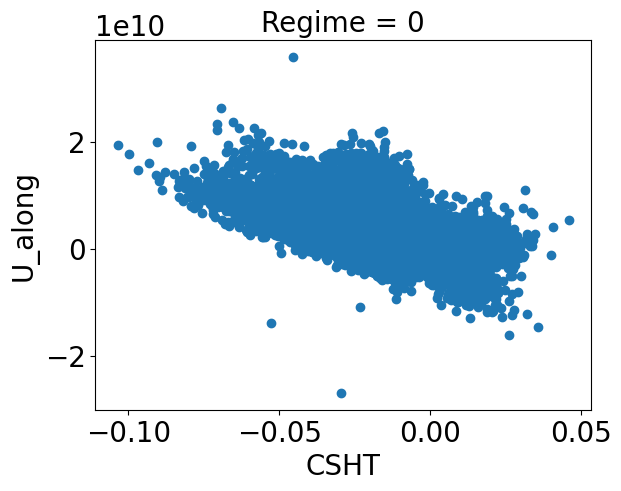

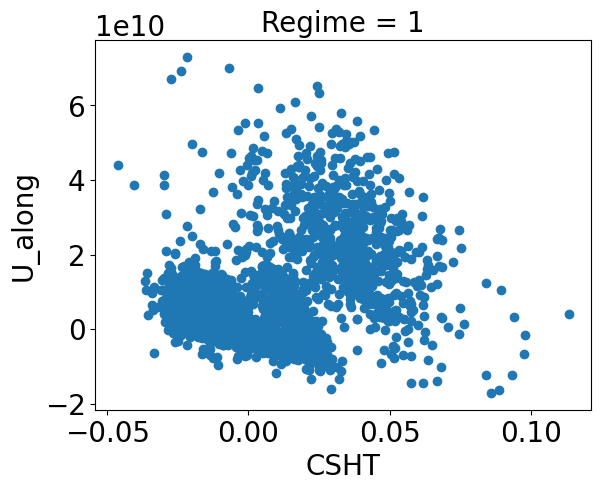

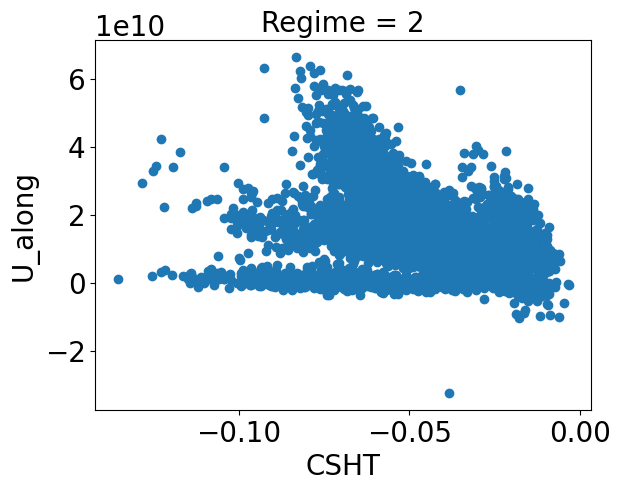

In [48]:
CSHT_sliced = CSHT_layerwise_binned.isel(depth=slice(37,50)).mean('depth').stack(z=['lon_bins','time'])
#CSHT_sliced = CSHT_layerwise_binned.isel(depth=slice(37,50)).stack(z=['depth','lon_bins','time'])


# scatter over lon bins and time, dpeth averaged over selected range
U_along_sliced = u_along_layerwise_binned.isel(depth=slice(37,50)).mean('depth').stack(z=['lon_bins','time'])
#U_along_sliced_depthav = u_along_layerwise_binned.weighted(u_along_layerwise_binned.depth).mean('depth').stack(z=['lon_bins','time'])
#U_along_sliced = u_along_layerwise_binned.isel(depth=slice(37,50)).stack(z=['depth','lon_bins','time'])

### for depth av 
U_along_sliced_depthav = U_along_depthav.stack(z=['lon_bins','time'])

## This is only for monthly data - not the climatology, daily, annual!
for i in range(U_along_sliced.regimes.size):
    plt.scatter(U_along_sliced.isel(regimes=i),\
                CSHT_sliced.isel(regimes=i))
    plt.title('Regime = '+str(i))
    plt.xlabel('CSHT')
    plt.ylabel('U_along')
    plt.show()

In [68]:
client.run(gc.collect)

{'tcp://127.0.0.1:33039': 223,
 'tcp://127.0.0.1:39187': 118,
 'tcp://127.0.0.1:39481': 97,
 'tcp://127.0.0.1:42403': 76,
 'tcp://127.0.0.1:42951': 56,
 'tcp://127.0.0.1:45663': 97,
 'tcp://127.0.0.1:45861': 118}

In [49]:
%%time
## Now, we use Kernel Density Estimation to turn the scatter plots to PDFs! 
## We need to divide by standard deviation to avoid skewed Gaussians being fit onto the scatter plot.
## We also need to remove all NaNs for the KDE to work. 
## We will multiply by STD in the plotting part :)

# Initialize variables
x_grid = np.zeros((3,500,500))
y_grid = np.zeros((3,500,500))
pdf_gauss = np.zeros((3,500,500))
pdf_gauss_depthav = np.zeros((3,500,500))
'''
for i in range(U_along_sliced.regimes.size):
    y,x = CSHT_sliced.isel(regimes=i).dropna(dim='z',how='all')\
    /np.std(CSHT_sliced.isel(regimes=i).dropna(dim='z',how='all')),\
    U_along_sliced.isel(regimes=i).dropna(dim='z',how='all')\
    /np.std(U_along_sliced.isel(regimes=i).dropna(dim='z',how='all'))

    # Create a grid to evaluate the PDF
    YY = np.linspace(np.min(y), np.max(y), 500)
    XX = np.linspace(np.min(x), np.max(x), 500)

    x_grid[i,:,:], y_grid[i,:,:] = np.meshgrid(XX, YY)
    grid_points = np.c_[x_grid[i,:,:].ravel(), y_grid[i,:,:].ravel()]
    # Create KDE object
    kde_gauss = KernelDensity(bandwidth=.05, kernel='gaussian')
    # Stack x and y values vertically
    combo_results = np.column_stack([x, y])
    # Fit KDE to the data
    kde_gauss.fit(combo_results)
    # Compute the log density evaluations for each point in the grid
    log_pdf = kde_gauss.score_samples(grid_points)
    
    # Reshape log density evaluations to match the shape of the grid
    pdf_gauss[i,:,:] = np.exp(log_pdf).reshape(x_grid[i,:,:].shape)
    '''

CPU times: user 6.31 ms, sys: 0 ns, total: 6.31 ms
Wall time: 4.28 ms


"\nfor i in range(U_along_sliced.regimes.size):\n    y,x = CSHT_sliced.isel(regimes=i).dropna(dim='z',how='all')    /np.std(CSHT_sliced.isel(regimes=i).dropna(dim='z',how='all')),    U_along_sliced.isel(regimes=i).dropna(dim='z',how='all')    /np.std(U_along_sliced.isel(regimes=i).dropna(dim='z',how='all'))\n\n    # Create a grid to evaluate the PDF\n    YY = np.linspace(np.min(y), np.max(y), 500)\n    XX = np.linspace(np.min(x), np.max(x), 500)\n\n    x_grid[i,:,:], y_grid[i,:,:] = np.meshgrid(XX, YY)\n    grid_points = np.c_[x_grid[i,:,:].ravel(), y_grid[i,:,:].ravel()]\n    # Create KDE object\n    kde_gauss = KernelDensity(bandwidth=.05, kernel='gaussian')\n    # Stack x and y values vertically\n    combo_results = np.column_stack([x, y])\n    # Fit KDE to the data\n    kde_gauss.fit(combo_results)\n    # Compute the log density evaluations for each point in the grid\n    log_pdf = kde_gauss.score_samples(grid_points)\n    \n    # Reshape log density evaluations to match the shape 

In [50]:
def pdf_gauss_creation(CSHT_sliced, U_along_sliced):
    
    for i in range(U_along_sliced.regimes.size):
        y,x = CSHT_sliced.isel(regimes=i).dropna(dim='z',how='all')\
        /np.std(CSHT_sliced.isel(regimes=i).dropna(dim='z',how='all')),\
        U_along_sliced.isel(regimes=i).dropna(dim='z',how='all')\
        /np.std(U_along_sliced.isel(regimes=i).dropna(dim='z',how='all'))
    
        # Create a grid to evaluate the PDF
        YY = np.linspace(np.min(y), np.max(y), 500)
        XX = np.linspace(np.min(x), np.max(x), 500)
    
        x_grid[i,:,:], y_grid[i,:,:] = np.meshgrid(XX, YY)
        grid_points = np.c_[x_grid[i,:,:].ravel(), y_grid[i,:,:].ravel()]
        # Create KDE object
        kde_gauss = KernelDensity(bandwidth=.05, kernel='gaussian')
        # Stack x and y values vertically
        combo_results = np.column_stack([x, y])
        # Fit KDE to the data
        kde_gauss.fit(combo_results)
        # Compute the log density evaluations for each point in the grid
        log_pdf = kde_gauss.score_samples(grid_points)
        
        # Reshape log density evaluations to match the shape of the grid
        pdf_gauss[i,:,:] = np.exp(log_pdf).reshape(x_grid[i,:,:].shape)

    return pdf_gauss, x_grid, y_grid

In [51]:
def generate_opacity_colormap(color, alpha_values):
    """
    Generate a custom colormap with varying opacity for a given color.

    Parameters:
        color (tuple): RGB values of the color.
        alpha_values (list): List of alpha values, ranging from 0 (fully transparent) to 1 (fully opaque).

    Returns:
        LinearSegmentedColormap: Custom colormap.
    """
    n = len(alpha_values)
    colors = [(*color, alpha) for alpha in alpha_values]
    positions = np.linspace(0, 1, n)
    return LinearSegmentedColormap.from_list("custom_colormap", list(zip(positions, colors)))

### Example plot 

Text(0, 0.5, 'U_along')

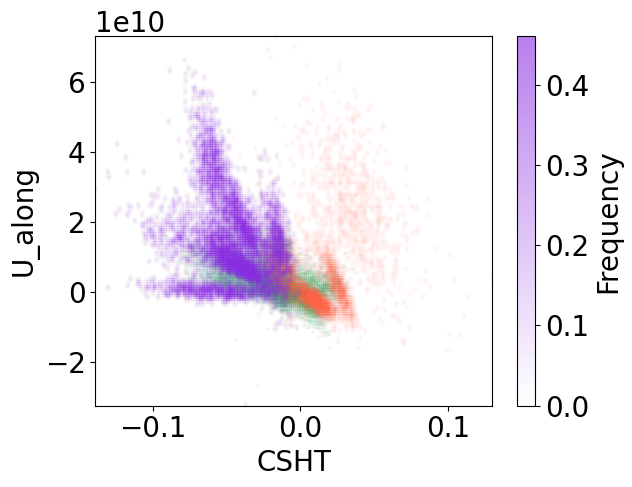

In [56]:
## Define the min, max alphas - modify this if the distributions overlap significantly
min_alpha, max_alpha = 0, 0.6
# Define the colors
base_color = to_rgb(colorsList_no3[0])#to_rgb('red')
base_color2 = to_rgb(colorsList_no3[1])#to_rgb('green')
base_color3 = to_rgb(colorsList_no3[2])#to_rgb('blue')

alpha_values = np.linspace(min_alpha, max_alpha, 256)  # Varying alpha values

# Generate the custom colormap
custom_cmap = generate_opacity_colormap(base_color, alpha_values)
custom_cmap2 = generate_opacity_colormap(base_color2, alpha_values)
custom_cmap3 = generate_opacity_colormap(base_color3, alpha_values)
cmaps = [custom_cmap,custom_cmap2,custom_cmap3]

# Plot the KDEs with a transparent colorbar
for i in range(U_along_sliced.regimes.size):
    plt.pcolor(x_grid[i,:,:]*np.std(U_along_sliced.isel(regimes=i).dropna(dim='z',how='all')).values, \
           y_grid[i,:,:]*np.std(CSHT_sliced.isel(regimes=i).dropna(dim='z',how='all')).values,\
           pdf_gauss[i,:,:],cmap=cmaps[i],linewidth=0,rasterized=True)
plt.colorbar(label='Frequency')
plt.xlabel('CSHT')
plt.ylabel('U_along')

## Plotting full

In [52]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [53]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [54]:
r_sq_depthav_binned_av[:,0]

array([0.07772353, 0.06308248, 0.05752682, 0.05312809, 0.04858232,
       0.04472031, 0.0432938 , 0.04744592, 0.05934382, 0.08104509,
       0.11296418, 0.1534118 , 0.19824895, 0.23994321, 0.27229986,
       0.29279374, 0.29871291, 0.28991046, 0.26835601, 0.2369388 ,
       0.20087655, 0.16902187, 0.1456116 , 0.12966426, 0.11664835,
       0.10451107, 0.09339883, 0.08239941, 0.07550635, 0.07330224,
       0.08165517, 0.0936089 , 0.10478394, 0.12159929, 0.11853827,
       0.1169016 , 0.13575667, 0.18232271, 0.20165051, 0.26112965,
       0.26774815, 0.27833857, 0.34989319, 0.41328847, 0.42448711,
       0.31753569, 0.22931448, 0.01891571, 0.0197923 , 0.01174396])

In [60]:
pdf_gaussav, x_gridav, y_gridav =  pdf_gauss_creation(CSHT_sliced, U_along_sliced_depthav)
pdf_gauss, x_grid, y_grid =  pdf_gauss_creation(CSHT_sliced, U_along_sliced)


i = 0, plotting pdf


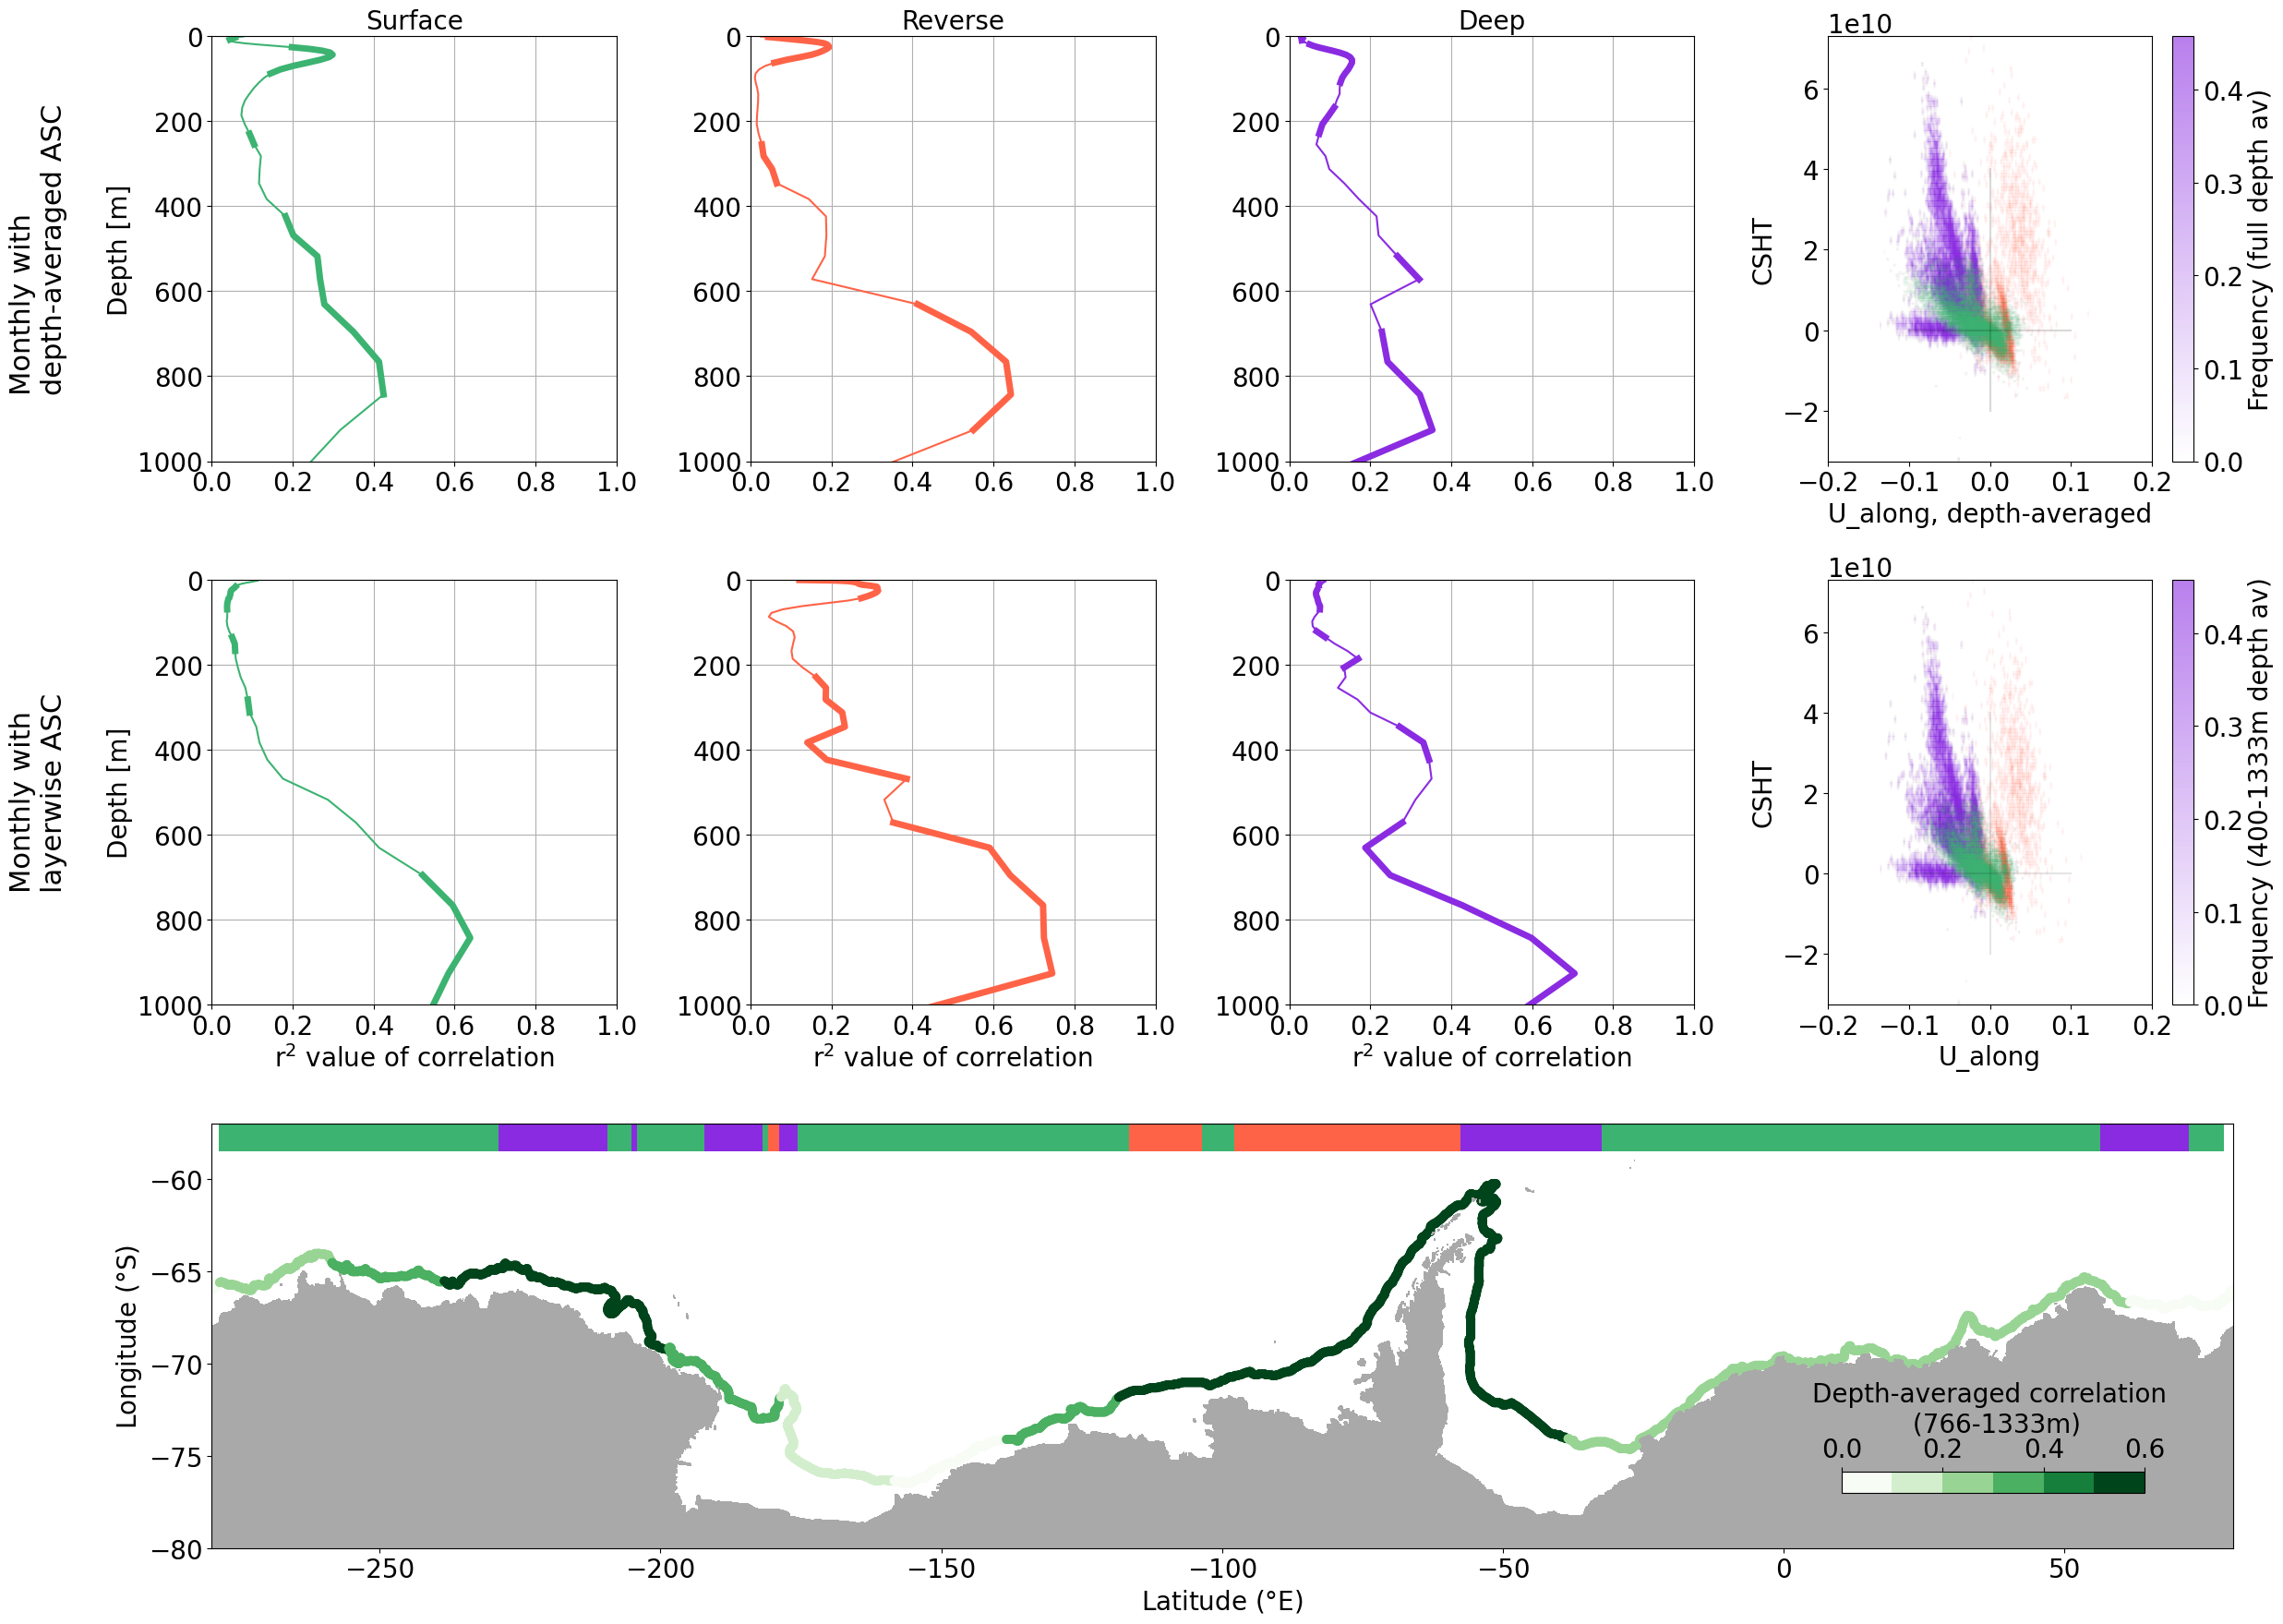

In [63]:
## With changing line thickness past threshold p value
## pdf with xgrid for depth av and onlt 433-1000m depth av
fig =  plt.figure(figsize=(25,18))
plt.subplots_adjust(hspace = 0.2, wspace=0.25)
axs = [plt.subplot(3,4,i) for i in range(1,9)]
thresholdp = 0.95

for i in range(3): # going through regimes in i

    ## r^2 of regimes
    axs[i].set_title(classes[i])
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(1000,0)
    axs[i+4].set_xlabel('r$^2$ value of correlation')
    axs[i].plot(r_sq_depthav_binned_av[:,i], binned_corr.depth,color  = colorsList_no3[i], label = 'r-squared')
    axs[i].plot(np.where(pval_depthav_binned_av[:,i]>thresholdp, r_sq_depthav_binned_av[:,i], np.nan), binned_corr.depth, color  = colorsList_no3[i], label = 'r-squared', lw = 5)

    ## domain av correlation
    axs[i+4].set_xlim(0,1)
    axs[i+4].set_ylim(1000,0)
    axs[i+4].plot(r_sq_annual_wavg_20deg[:,i], binned_corr.depth, color  = colorsList_no3[i], label = 'r-squared')
    axs[i+4].plot(np.where(pval_binned_av[:,i]>thresholdp, r_sq_annual_wavg_20deg[:,i], np.nan), binned_corr.depth, color  = colorsList_no3[i], label = 'r-squared', lw =5)
    
    axs[0].set_ylabel('Depth [m]')
    axs[4].set_ylabel('Depth [m]')
    #axs[6].set_ylabel('Depth [m]')

    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)


    axs[i].grid()
    axs[i+4].invert_yaxis()
    axs[i+4].set_ylim(1000,0)
    axs[i+4].grid()


    ## PLOTTING PDF
    if i != 0:
        pmap = axs[3].pcolor(x_gridav[i,:,:]*np.std(U_along_sliced_depthav.isel(regimes=i).dropna(dim='z',how='all')).values, \
                   y_gridav[i,:,:]*np.std(CSHT_sliced.isel(regimes=i).dropna(dim='z',how='all')).values,\
                   pdf_gaussav[i,:,:],cmap=cmaps[i],linewidth=0,rasterized=True)
        axs[3].set_ylabel('CSHT')
        axs[3].set_xlabel('U_along, depth-averaged')
        if i == 2:
            plt.colorbar(pmap, ax = axs[3], label='Frequency (full depth av)')
        axs[3].plot([-0.1,0.1],[0,0],'k', alpha = 0.05)
        axs[3].plot([0,0],[-2e10,4e10],'k', alpha = 0.05)
        
        # Plot the KDEs with a transparent colorbar
        pmap = axs[7].pcolor(x_grid[i,:,:]*np.std(U_along_sliced.isel(regimes=i).dropna(dim='z',how='all')).values, \
                   y_grid[i,:,:]*np.std(CSHT_sliced.isel(regimes=i).dropna(dim='z',how='all')).values,\
                   pdf_gauss[i,:,:],cmap=cmaps[i],linewidth=0,rasterized=True)
        axs[7].set_ylabel('CSHT')
        axs[7].set_xlabel('U_along')
        if i == 2:
            plt.colorbar(pmap, ax = axs[7], label='Frequency (400-1333m depth av)')
        axs[7].plot([-0.1,0.1],[0,0],'k', alpha = 0.05)
        axs[7].plot([0,0],[-2e10,4e10],'k', alpha = 0.05)

        
axs[0].text(-0.5,0.5, 'Monthly with \ndepth-averaged ASC',  rotation=90, va= 'center', transform = axs[0].transAxes, fontsize = 22)
axs[4].text(-0.5,0.5, 'Monthly with \nlayerwise ASC', rotation=90, va= 'center', transform = axs[4].transAxes, fontsize = 22)

i = 0
pmap = axs[3].pcolor(x_gridav[i,:,:]*np.std(U_along_sliced_depthav.isel(regimes=i).dropna(dim='z',how='all')).values, \
                   y_gridav[i,:,:]*np.std(CSHT_sliced.isel(regimes=i).dropna(dim='z',how='all')).values,\
                   pdf_gaussav[i,:,:],cmap=cmaps[i],linewidth=0,rasterized=True)
axs[3].set_ylabel('CSHT')
axs[3].set_xlabel('U_along, depth-averaged')
print('i = 0, plotting pdf')
axs[3].plot([-0.1,0.1],[0,0],'k', alpha = 0.05)
axs[3].plot([0,0],[-2e10,4e10],'k', alpha = 0.05)

# Plot the KDEs with a transparent colorbar
pmap = axs[7].pcolor(x_grid[i,:,:]*np.std(U_along_sliced.isel(regimes=i).dropna(dim='z',how='all')).values, \
           y_grid[i,:,:]*np.std(CSHT_sliced.isel(regimes=i).dropna(dim='z',how='all')).values,\
           pdf_gauss[i,:,:],cmap=cmaps[i],linewidth=0,rasterized=True)

axs[3].set_xlim([-0.2,0.2])
axs[7].set_xlim([-0.2,0.2])

## Plotting spatial depth-average correlation?
ax_cric = plt.subplot(313)
cmap = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = da_binned_corr_max, cmap = discrete_cmap(6, 'Greens'), vmin = 0, vmax = 0.6)
ax_cric.pcolormesh(clustering_mask.lon, [-58,-57],  np.vstack((clustering_mask_sum,clustering_mask_sum)) , cmap=CustomCmap_no3)

axins1 = inset_axes(
    ax_cric,
    width="15%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower left',
    bbox_to_anchor = (0.8,0.1,1,1),
    bbox_transform=ax_cric.transAxes

)

cb = fig.colorbar(cmap, cax = axins1, orientation = 'horizontal', label = 'Depth-averaged correlation \n (766-1333m)')
cb.set_ticks([0,0.2,0.4,0.6])
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")

ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax_cric.set_ylim([-80,-57])
ax_cric.set_ylabel('Longitude ($\degree$S)')
ax_cric.set_xlabel('Latitude ($\degree$E)')

#ax1.legend(loc=4)
plt.tight_layout()
plt.show()

## hide

In [20]:
## getting p-values from binned data
CSHT_layerwise_binned = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/CSHT_layerwise_5degBins.nc').CSHT_layerwise_binned.load()
u_along_layerwise_binned = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/u_along_da_months_5degBins.nc').u_along_da_months_binned.load()

In [22]:
u_along_layerwise_binned.depth

<xarray.DataArray 'depth' (depth: 50)>
array([4.060389e-04, 1.260794e-03, 2.205390e-03, 3.249268e-03, 4.402862e-03,
       5.677703e-03, 7.086531e-03, 8.643426e-03, 1.036395e-02, 1.226528e-02,
       1.436643e-02, 1.668837e-02, 1.925431e-02, 2.208985e-02, 2.522332e-02,
       2.868596e-02, 3.251233e-02, 3.674056e-02, 4.141279e-02, 4.657554e-02,
       5.228015e-02, 5.858331e-02, 6.554756e-02, 7.324188e-02, 8.174233e-02,
       9.113273e-02, 1.015054e-01, 1.129619e-01, 1.256140e-01, 1.395843e-01,
       1.550073e-01, 1.720304e-01, 1.908144e-01, 2.115348e-01, 2.343821e-01,
       2.595626e-01, 2.872984e-01, 3.178276e-01, 3.514034e-01, 3.882930e-01,
       4.287752e-01, 4.731370e-01, 5.216693e-01, 5.746610e-01, 6.323912e-01,
       6.951203e-01, 7.630800e-01, 8.364624e-01, 9.154087e-01, 1.000000e+00])
Coordinates:
  * depth    (depth) float64 0.000406 0.001261 0.002205 ... 0.8365 0.9154 1.0

In [23]:
binned_corr.depth

<xarray.DataArray 'depth' (depth: 50)>
array([5.412807e-01, 1.680735e+00, 2.939953e+00, 4.331522e+00, 5.869350e+00,
       7.568810e+00, 9.446885e+00, 1.152234e+01, 1.381593e+01, 1.635055e+01,
       1.915154e+01, 2.224687e+01, 2.566746e+01, 2.944746e+01, 3.362460e+01,
       3.824057e+01, 4.334140e+01, 4.897796e+01, 5.520640e+01, 6.208874e+01,
       6.969342e+01, 7.809601e+01, 8.737988e+01, 9.763699e+01, 1.089687e+02,
       1.214869e+02, 1.353144e+02, 1.505868e+02, 1.674530e+02, 1.860765e+02,
       2.066365e+02, 2.293296e+02, 2.543701e+02, 2.819920e+02, 3.124492e+02,
       3.460166e+02, 3.829906e+02, 4.236883e+02, 4.684475e+02, 5.176241e+02,
       5.715899e+02, 6.307275e+02, 6.954248e+02, 7.660668e+02, 8.430255e+02,
       9.266482e+02, 1.017244e+03, 1.115068e+03, 1.220309e+03, 1.333076e+03])
Coordinates:
  * depth    (depth) float64 0.5413 1.681 2.94 ... 1.115e+03 1.22e+03 1.333e+03

In [90]:
pval_all_binned = np.zeros((u_along_layerwise_binned.depth.size, u_along_layerwise_binned.lon_bins.size, 3))

for i in range(3):
    for j in range(u_along_layerwise_binned.depth.size):
        for l in range(u_along_layerwise_binned.lon_bins.size):
            pval_all_binned[j,l,i] = 1-stats.linregress(u_along_layerwise_binned[i,:,j,l], CSHT_layerwise_binned[i,:,j,l]/1e12).pvalue

            #pval_all_binned[j,l,i] = 1-stats.linregress(u_along_layerwise_binned[i,:,j,l][~np.isnan(CSHT_layerwise_binned[i,:,j,l])], CSHT_layerwise_binned[i,:,j,l][~np.isnan(CSHT_layerwise_binned[i,:,j,l])]/1e12).pvalue
pval_binned_av = np.nanmean(pval_all_binned,axis = 1)
 # average over lon bins

In [115]:
binned_corr_av.shape

(50, 3)

In [111]:
binned_corr_av  = binned_corr.mean(dim = 'lon_bin_mid').r_sq_all
binned_corr_av

<xarray.DataArray 'r_sq_all' (depth: 50, regimes: 3)>
dask.array<mean_agg-aggregate, shape=(50, 3), dtype=float64, chunksize=(50, 3), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5413 1.681 2.94 ... 1.115e+03 1.22e+03 1.333e+03
  * regimes  (regimes) int64 0 1 2

# TO CHEKC IF 600-1400m IS BETTER OR 800-1000m is better

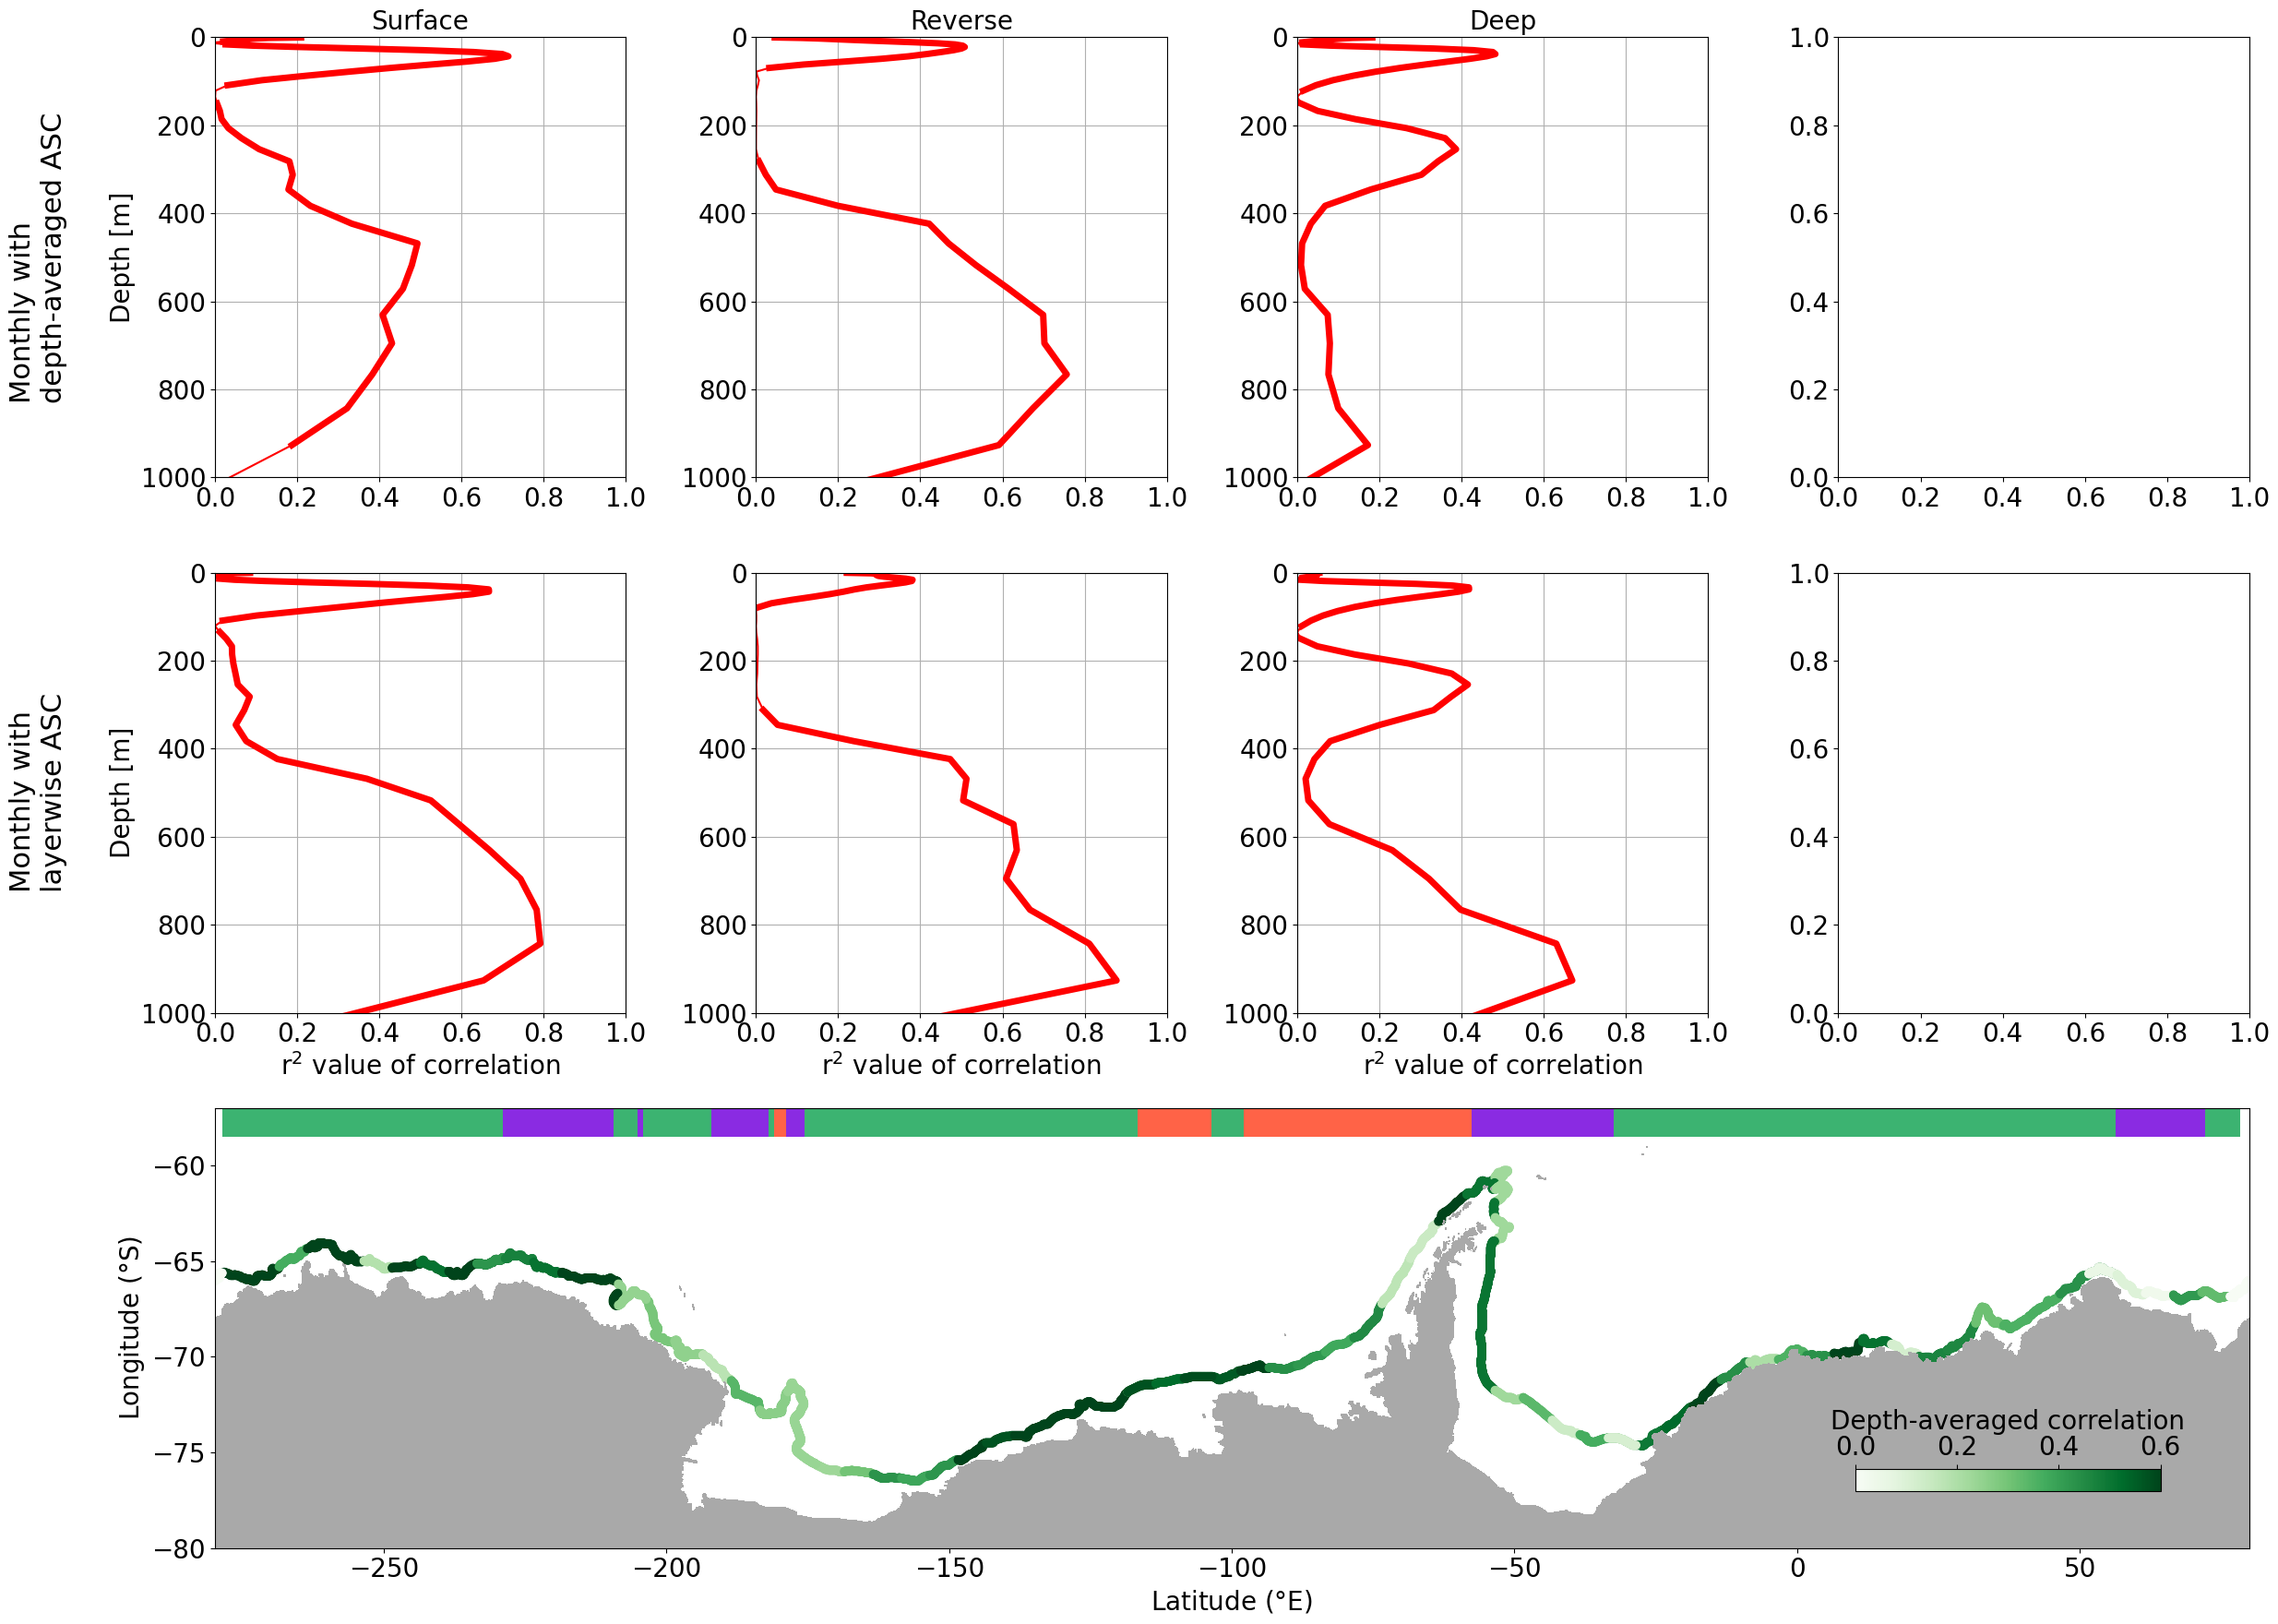

In [125]:
## With changing line thickness past threshold p value
fig =  plt.figure(figsize=(25,18))
plt.subplots_adjust(hspace = 0.2, wspace=0.25)
axs = [plt.subplot(3,4,i) for i in range(1,9)]
thresholdp = 0.95

for i in range(3): # going through regimes in i

    ## r^2 of regimes
    axs[i].set_title(classes[i])
    '''
    ax1 = axs[i].twiny()
    ax2 = axs[i+4].twiny()
    #ax3 = axs[i+6].twiny()
    '''
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(1000,0)
    axs[i+4].set_xlabel('r$^2$ value of correlation')
    axs[i].plot(r_sq_depthav[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    axs[i].plot(np.where(pval_depthav[:,i]>thresholdp,r_sq_depthav[:,i], np.nan), masked_u_along.depth, 'r', label = 'r-squared', lw = 5)

    '''
    ## using binned correlation
    axs[i+4].set_xlim(0,1)
    axs[i+4].set_ylim(1000,0)
    axs[i+4].plot(binned_corr_av[:,i], binned_corr_av.depth, 'r', label = 'r-squared')
    axs[i+4].plot(np.where(pval_binned_av[:,i]>thresholdp, binned_corr_av[:,i], np.nan), binned_corr_av.depth, 'r', label = 'r-squared', lw =5)
    '''
    ## domain av correlation
    axs[i+4].set_xlim(0,1)
    axs[i+4].set_ylim(1000,0)
    axs[i+4].plot(r_sq_all[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    axs[i+4].plot(np.where(pval_all[:,i]>thresholdp, r_sq_all[:,i], np.nan), masked_u_along.depth, 'r', label = 'r-squared', lw =5)
    
    axs[0].set_ylabel('Depth [m]')
    axs[4].set_ylabel('Depth [m]')
    #axs[6].set_ylabel('Depth [m]')

    #axs[i+6].set_xlabel('Cross-slope heat transport change\n per unit along-slope velocity change [TJ/m]')
    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    #axs[3*i].set_xlim(-1.1,0.1)
    #axs[3*i+1].set_xlim(-2,0.6)
    #axs[3*i+2].set_xlim(-2.1,0.4)

    axs[i].grid()
    axs[i+4].invert_yaxis()
    axs[i+4].set_ylim(1000,0)
    axs[i+4].grid()
    #axs[i+6].invert_yaxis()
    #axs[i+6].set_ylim(1000,0)
    #axs[i+6].grid()
    #axs[1].legend()

axs[0].text(-0.5,0.5, 'Monthly with \ndepth-averaged ASC',  rotation=90, va= 'center', transform = axs[0].transAxes, fontsize = 22)
axs[4].text(-0.5,0.5, 'Monthly with \nlayerwise ASC', rotation=90, va= 'center', transform = axs[4].transAxes, fontsize = 22)


## Plotting spatial depth-average correlation
ax_cric = plt.subplot(313)
ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = da_binned_corr_av_ext.isel(regimes = 0), cmap = 'Greens', vmin = 0, vmax = 0.6)
ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = da_binned_corr_av_ext.isel(regimes = 1), cmap = 'Greens', vmin = 0, vmax = 0.6)
cmap = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = da_binned_corr_av_ext.isel(regimes = 2), cmap = 'Greens', vmin = 0, vmax = 0.6)
ax_cric.pcolormesh(clustering_mask.lon, [-58,-57],  np.vstack((clustering_mask_sum,clustering_mask_sum)) , cmap=CustomCmap_no3)

axins1 = inset_axes(
    ax_cric,
    width="15%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower left',
    bbox_to_anchor = (0.8,0.1,1,1),
    bbox_transform=ax_cric.transAxes

)

cb = fig.colorbar(cmap, cax = axins1, orientation = 'horizontal', label = 'Depth-averaged correlation')
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")

ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax_cric.set_ylim([-80,-57])
ax_cric.set_ylabel('Longitude ($\degree$S)')
ax_cric.set_xlabel('Latitude ($\degree$E)')

#ax1.legend(loc=4)
plt.tight_layout()
plt.show()

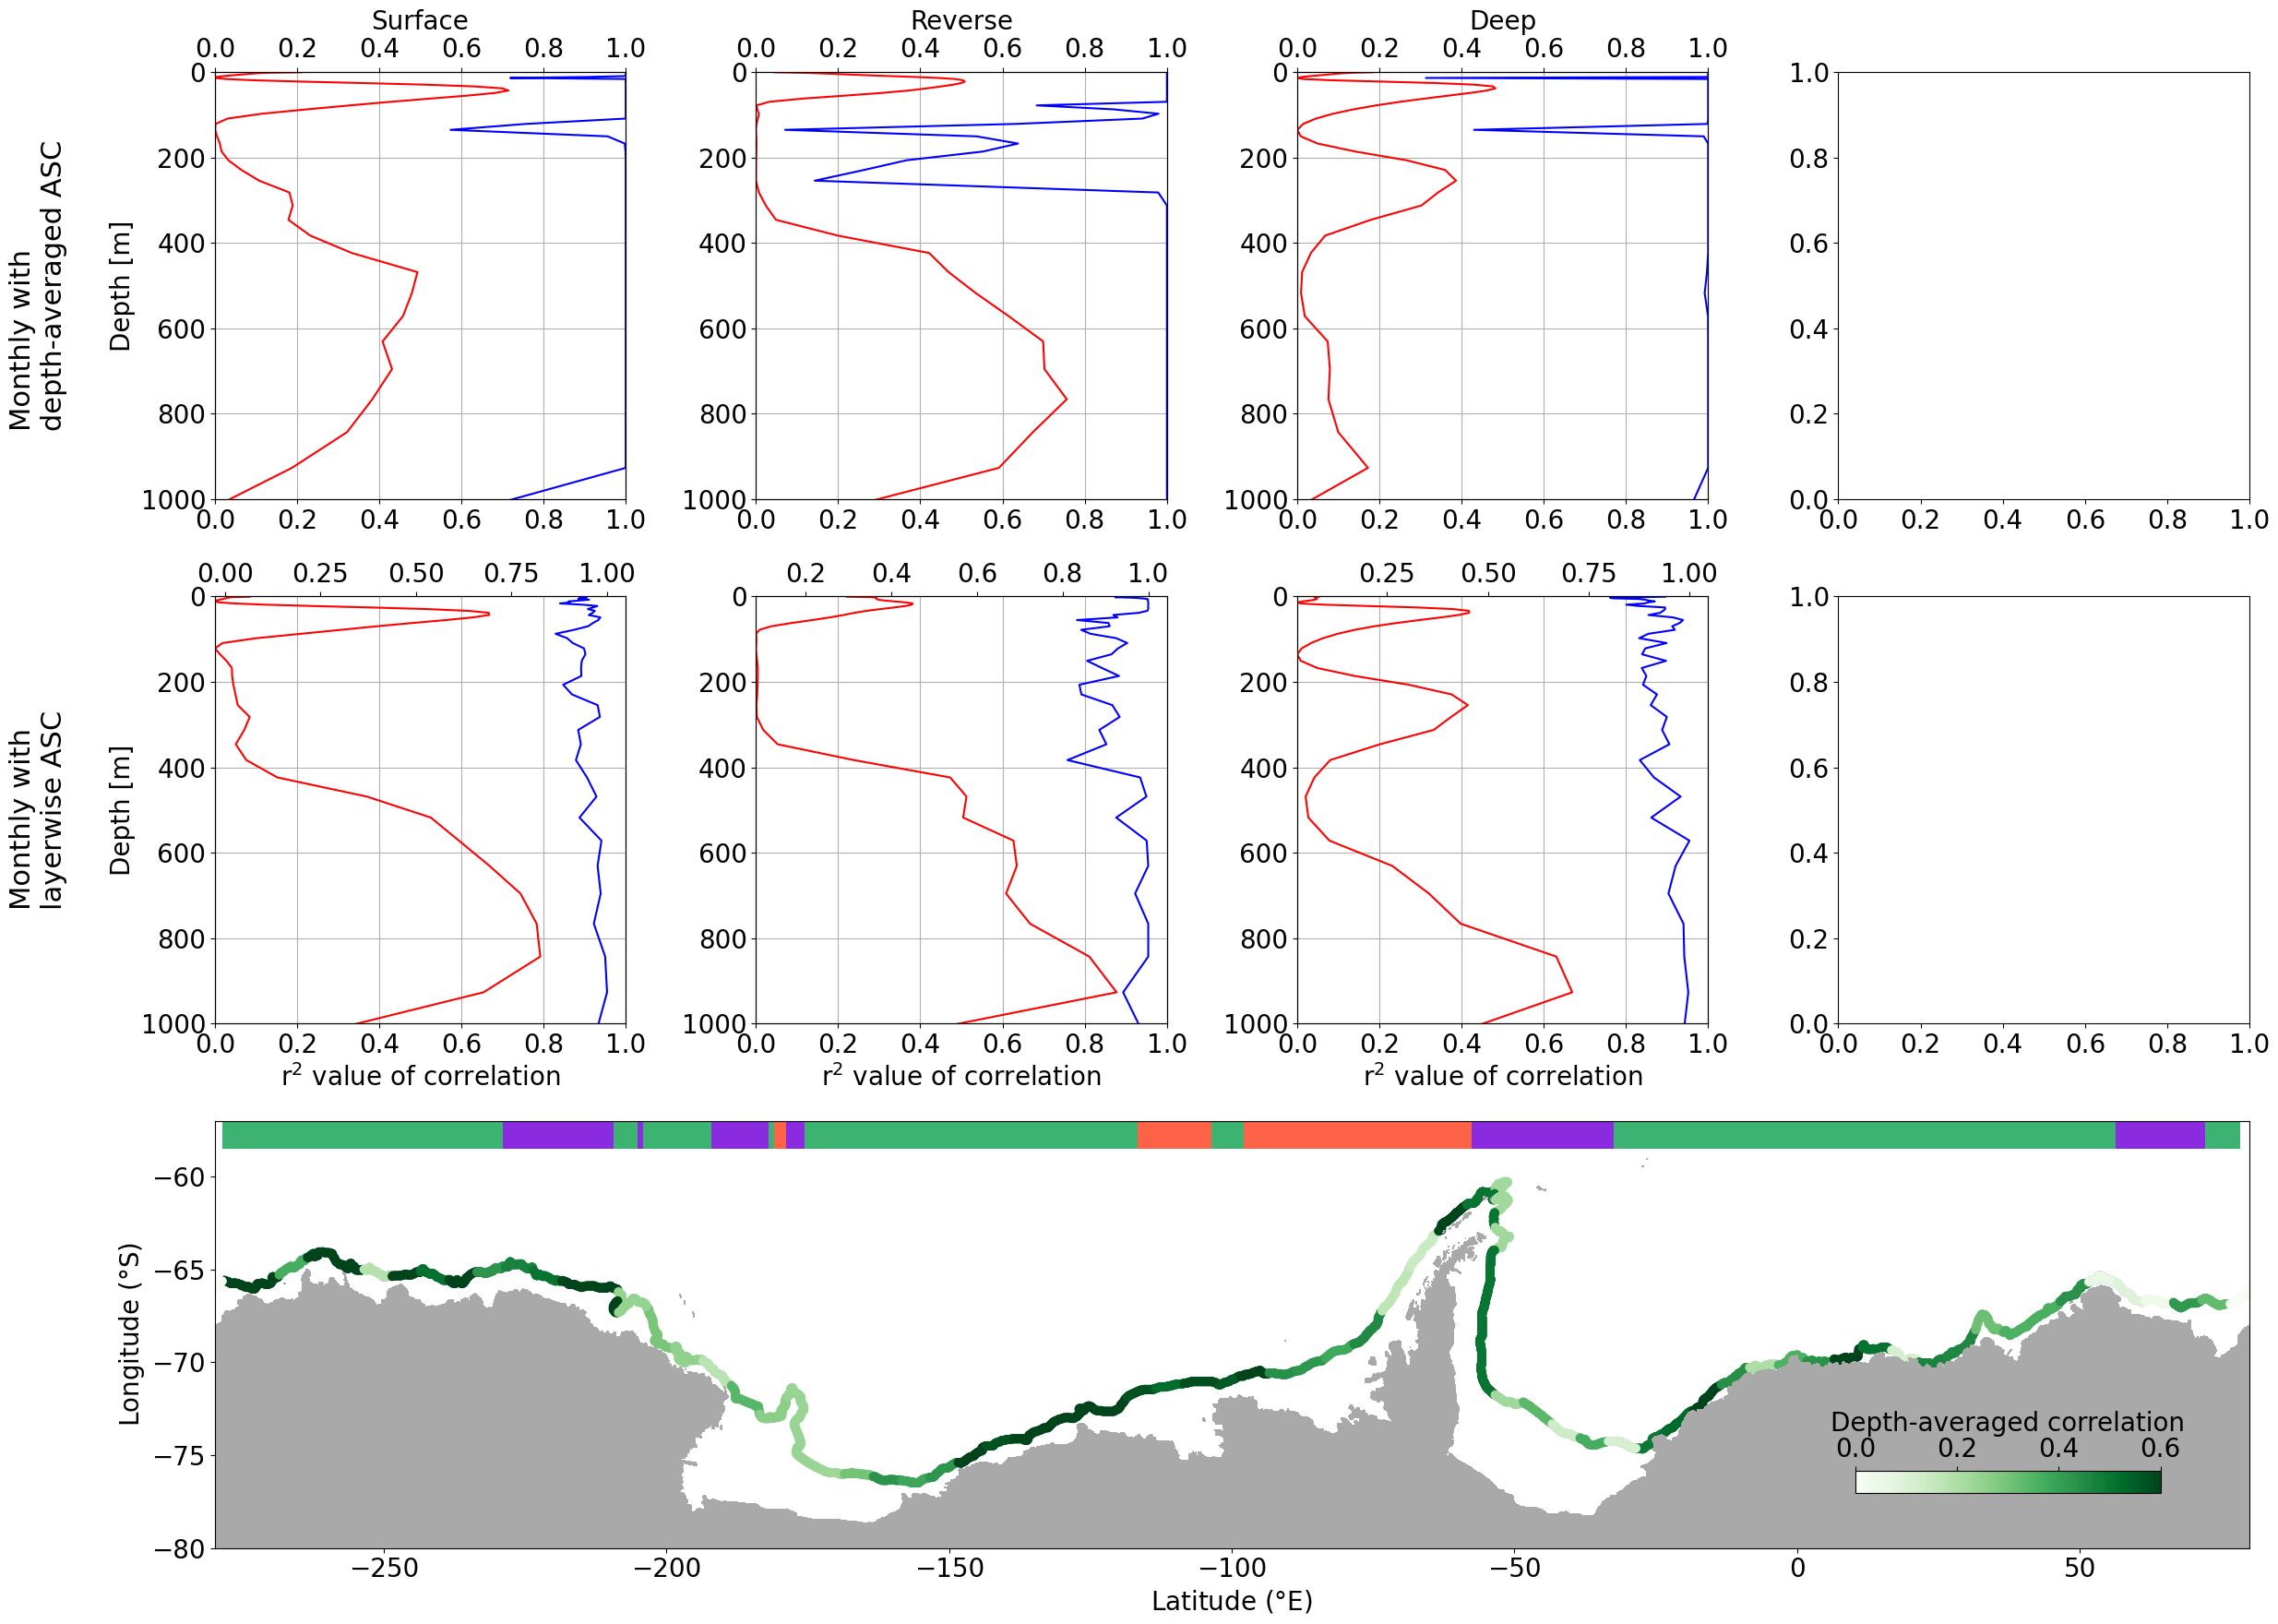

In [102]:
fig =  plt.figure(figsize=(25,18))
plt.subplots_adjust(hspace = 0.2, wspace=0.25)
axs = [plt.subplot(3,4,i) for i in range(1,9)]

for i in range(3): # going through regimes in i

    ## r^2 of regimes
    axs[i].set_title(classes[i])
    '''
    ax1 = axs[i].twiny()
    ax2 = axs[i+4].twiny()
    #ax3 = axs[i+6].twiny()
    '''
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(1000,0)
    axs[i+4].set_xlabel('r$^2$ value of correlation')
    axs[i].plot(r_sq_depthav[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    axs[i+4].set_xlim(0,1)
    axs[i+4].set_ylim(1000,0)
    axs[i+4].plot(r_sq_all[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    #ax3.set_xlim(0,1)
    #ax3.set_ylim(1000,0)
    #ax3.plot(r_sq_clima[:,i], masked_u_along.depth, 'r', label = 'r-squared')

    ax1 = axs[i].twiny()
    ax1.plot(pval_depthav[:,i], masked_u_along.depth, 'b', label = 'significance')
    ax1.set_xlim(0,1)
    axs[i+4].set_ylim(1000,0)
    ax2 = axs[i+4].twiny()
    ax2.plot(pval_binned_av[:,i], binned_corr.depth, 'b', label = 'significance')


    axs[0].set_ylabel('Depth [m]')
    axs[4].set_ylabel('Depth [m]')
    #axs[6].set_ylabel('Depth [m]')

    #axs[i+6].set_xlabel('Cross-slope heat transport change\n per unit along-slope velocity change [TJ/m]')
    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    #axs[3*i].set_xlim(-1.1,0.1)
    #axs[3*i+1].set_xlim(-2,0.6)
    #axs[3*i+2].set_xlim(-2.1,0.4)

    axs[i].grid()
    axs[i+4].invert_yaxis()
    axs[i+4].set_ylim(1000,0)
    axs[i+4].grid()
    #axs[i+6].invert_yaxis()
    #axs[i+6].set_ylim(1000,0)
    #axs[i+6].grid()
    #axs[1].legend()

axs[0].text(-0.5,0.5, 'Monthly with \ndepth-averaged ASC',  rotation=90, va= 'center', transform = axs[0].transAxes, fontsize = 22)
axs[4].text(-0.5,0.5, 'Monthly with \nlayerwise ASC', rotation=90, va= 'center', transform = axs[4].transAxes, fontsize = 22)


## Plotting spatial depth-average correlation
ax_cric = plt.subplot(313)
ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = da_binned_corr_av_ext.isel(regimes = 0), cmap = 'Greens', vmin = 0, vmax = 0.6)
ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = da_binned_corr_av_ext.isel(regimes = 1), cmap = 'Greens', vmin = 0, vmax = 0.6)
cmap = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = da_binned_corr_av_ext.isel(regimes = 2), cmap = 'Greens', vmin = 0, vmax = 0.6)
ax_cric.pcolormesh(clustering_mask.lon, [-58,-57],  np.vstack((clustering_mask_sum,clustering_mask_sum)) , cmap=CustomCmap_no3)

axins1 = inset_axes(
    ax_cric,
    width="15%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower left',
    bbox_to_anchor = (0.8,0.1,1,1),
    bbox_transform=ax_cric.transAxes

)

cb = fig.colorbar(cmap, cax = axins1, orientation = 'horizontal', label = 'Depth-averaged correlation')
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")

ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax_cric.set_ylim([-80,-57])
ax_cric.set_ylabel('Longitude ($\degree$S)')
ax_cric.set_xlabel('Latitude ($\degree$E)')

#ax1.legend(loc=4)
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,8))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

for i in range(3): # going through regimes in i

    axs[i].set_title(classes[i], fontsize=14)
    '''
    ax1 = axs[i].twiny()
    ax2 = axs[i+4].twiny()
    #ax3 = axs[i+6].twiny()
    '''
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(1000,0)
    axs[i+4].set_xlabel('r$^2$ value of correlation')
    axs[i].plot(r_sq_depthav[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    axs[i+4].set_xlim(0,1)
    axs[i+4].set_ylim(1000,0)
    axs[i+4].plot(r_sq_all[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    #ax3.set_xlim(0,1)
    #ax3.set_ylim(1000,0)
    #ax3.plot(r_sq_clima[:,i], masked_u_along.depth, 'r', label = 'r-squared')

    axs[0].set_ylabel('Depth [m]')
    axs[4].set_ylabel('Depth [m]')
    #axs[6].set_ylabel('Depth [m]')

    #axs[i+6].set_xlabel('Cross-slope heat transport change\n per unit along-slope velocity change [TJ/m]')
    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    #axs[3*i].set_xlim(-1.1,0.1)
    #axs[3*i+1].set_xlim(-2,0.6)
    #axs[3*i+2].set_xlim(-2.1,0.4)

    axs[i].grid()
    axs[i+4].invert_yaxis()
    axs[i+4].set_ylim(1000,0)
    axs[i+4].grid()
    #axs[i+6].invert_yaxis()
    #axs[i+6].set_ylim(1000,0)
    #axs[i+6].grid()
    #axs[1].legend()

axs[0].text(-0.5,0.5, 'Monthly with \ndepth-averaged ASC', fontsize = 14, rotation=90, va= 'center', transform = axs[0].transAxes)
axs[4].text(-0.5,0.5, 'Monthly with \nlayerwise ASC', fontsize = 14, rotation=90, va= 'center', transform = axs[4].transAxes)


#ax1.legend(loc=4)
plt.show()